# 1D Discontinuous Galerkin Shallow Water Solver

We solve the 1D Shallow Water Equations in conservative form:

\begin{align*}
    h_t + q_x &= 0 \\
    q_t + \left[ \frac{q^2}{h} + \frac{1}{2} g h^2 \right]_x &= -g h b_x - C_f \left(\frac{q}{h}\right)^2
\end{align*}

In this notebook, we neglect friction so that $C_f = 0$.

We begin by importing appropriate libraries, modules, etc. and defining our physical domain. We'll define initial conditions for height and flow and plot these against the system's variable bathymetry:

<IPython.core.display.Javascript object>


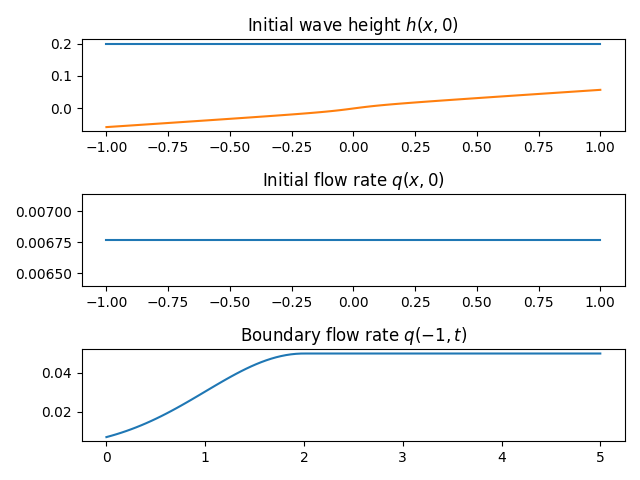

In [16]:
# Enable interactive plots
#
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt


import bc
import fluxes
import quadrature
import rk
import swe_1d


# Physical parameters
#
g = 1.0  # gravity

# Domain
#
tspan = (0.0, 5.0)
xspan = (-1, 1)

# Bathymetry parameters
#
b_smoothness = 0.1
b_amplitude = 0.005
b_slope = 0.05
assert(b_smoothness > 0)

# Inflow parameters
#
inflow_amplitude = 0.05
inflow_smoothness = 1.0
inflow_peak_time = 2.0
assert(inflow_amplitude > 0)

# Initial waveheight
#
h0 = 0.2
assert(h0 > 0)


def swe_bathymetry(x):
    """
    Describes bathymetry with an upslope which is perturbed by a hyperbolic tangent function.
    """
    return b_slope * x + b_amplitude * np.arctan(x/b_smoothness)


def swe_bathymetry_derivative(x):
    """
    Derivative of swe_bathymetry
    """
    return b_slope * np.ones(x.shape) + b_amplitude * b_smoothness/(1 + np.square(b_smoothness*x)) * np.exp(-np.square(b_smoothness*x))


def q_bc(t):
    """
    Describes a Gaussian inflow, where the function transitions to a constant value upon attaining
    its maximum value.

    :param t: Time
    :return:
    """
    tt = np.array(t)
    return inflow_amplitude * np.exp( -np.square(np.minimum(tt, inflow_peak_time * np.ones(tt.shape)) - inflow_peak_time) / (2 * np.square(inflow_smoothness)) )


def initial_condition(x):
    """
    Creates initial conditions for (h, uh).

    :param x: Computational domain
    :return:
    """
    initial_height = h0 * np.ones(x.shape) - swe_bathymetry(x)  # horizontal water surface
    initial_flow = q_bc(0) * np.ones(x.shape)  # Start with whatever flow is prescribed by our inflow BC

    ic = np.array((
        initial_height,
        initial_flow,
    ))

    # Verify consistency of initial condition
    #
    if not np.allclose(ic[1][0], q_bc(0)):
        raise ValueError('Initial flow condition must match prescribed inflow.')

    return ic

# Plot bathymetry and ICs
#
xl, xr = xspan
t0, tf = tspan

xx = np.linspace(xl, xr, num=100)
tt = np.linspace(t0, tf, num=100)

fig, (h_ax, hv_ax, q_bc_ax) = plt.subplots(3, 1)

ic = initial_condition(xx)
bb = swe_bathymetry(xx)
qq_bc = q_bc(tt)

# Plot initial wave height and bathymetry
#
h_ax.plot(xx, ic[0] + bb)
h_ax.plot(xx, bb)
h_ax.set_title('Initial wave height $h(x, 0)$')

# Plot initial flow rate
#
hv_ax.plot(xx, ic[1])
hv_ax.set_title('Initial flow rate $q(x, 0)$')

# Plot flow rate at left boundary over simulation time
#
q_bc_ax.plot(tt, qq_bc)
q_bc_ax.set_title('Boundary flow rate $q({}, t)$'.format(xl))

plt.tight_layout()

...at which point we are now ready to instantiate and run our solver:

Integrating ODE system...
Computing du/dt at t=0.7722628329853454
Computing du/dt at t=0.26554931400222703
Computing du/dt at t=0.5277792615794261
Computing du/dt at t=0.7900092091566252
Computing du/dt at t=1.055558523158854
Computing du/dt at t=1.3177884707360619
Computing du/dt at t=1.5800184183132697
Computing du/dt at t=1.8422483658904776
Computing du/dt at t=2.1077976798927134
Computing du/dt at t=2.3700276274699212
Computing du/dt at t=2.632257575047129
Computing du/dt at t=2.897806889049365
Computing du/dt at t=3.1600368366265728
Computing du/dt at t=3.4222667842037806
Computing du/dt at t=3.6844967317809885
Computing du/dt at t=3.9500460457832243
Computing du/dt at t=4.2122759933604605
Computing du/dt at t=4.4745059409377035
Computing du/dt at t=4.740055254939975


<IPython.core.display.Javascript object>


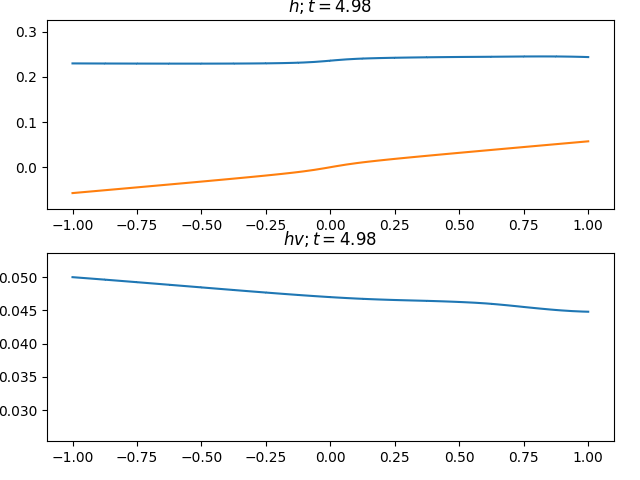

Writing movie to swe_1d.gif...
Saving animation frame 1/250
Saving animation frame 51/250
Saving animation frame 101/250
Saving animation frame 151/250
Saving animation frame 201/250
Animation written to swe_1d.gif.


In [2]:
# Instantiate solver with bathymetry
#
solver = swe_1d.ShallowWater1D(
    b=swe_bathymetry,
    b_x=swe_bathymetry_derivative,
    gravity=g
)


t_interval_ms = 20
dt = t_interval_ms / 1000
surface_flux = fluxes.lax_friedrichs_flux
print('Integrating ODE system...')
solution = solver.solve(
    tspan=tspan,
    xspan=xspan,
    cell_count=16,
    polydeg=4,
    initial_condition=initial_condition,
    intercell_flux=surface_flux,
    left_boundary_flux=swe_1d.ShallowWater1D.bc_prescribed_inflow(q_bc, gravity=g, surface_flux=surface_flux),
    right_boundary_flux=bc.transmissive_outflow(surface_flux=surface_flux),
    quad_rule=quadrature.gll,
    **{
        'method': rk.SSPRK33,
        't_eval': np.arange(tspan[0], tspan[1], dt),
        'max_step': dt,  # max time step for ODE solver
        'rtol': 1.0e-6,
        'atol': 1.0e-6,
    }
)

# Plot solution animation
#
ani, plt = solver.plot_animation(solution, frame_interval=t_interval_ms)
plt.show()

# Save animation to file
#
movie_name = 'swe_1d.gif'
print('Writing movie to {}...'.format(movie_name))

ani.save(movie_name, progress_callback=lambda i, n: print(
    f'Saving animation frame {i + 1}/{n}'
) if i % 50 == 0 else None)
print('Animation written to {}.'.format(movie_name))

Click [here](./swe_1d.gif) to view the GIF generated from the previous cell if the interactive plot above doesn't show up.